In [32]:
import os
import numpy as np
import pandas as pd
import joblib
import sys
sys.path.append('..')
from data_preprocess import *
from utils import get_config

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'figure.figsize':(8,6), 'figure.dpi':300}
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style='ticks',rc=rc)
sns.palplot(sns.color_palette(flatui))



In [8]:
seq_type = 'tp'
chr = '21'

In [11]:
from datetime import datetime
import re

def extract_phenotype_feature(in_df, del_outliers=False):

    out_cols = ['SAMPLE_NUM', 'ID_NUMBER', 'HEIGHT', 'WEIGHT', 'GESTATIONAL_WEEKS', 'BLOOD_DATE', 'FF']

    out_df = in_df[out_cols].copy()
    # out_df.loc[:, 'AGE'] = 0.0
    # out_df.loc[:, 'GESTATIONAL_WEEKS_D'] = 0.0

    # calculate AGE
    def getdob_fromid(x):
        y = x[6: 6+8]
        return datetime.strptime(y, '%Y%m%d')

    dob = out_df['ID_NUMBER'].apply(lambda x: getdob_fromid(x))
    abs_diff_time = pd.to_datetime(out_df['BLOOD_DATE']) - dob
    out_df['AGE'] = abs_diff_time.dt.total_seconds() / (60.0 * 60.0 * 24 * 365.25)
    # age = abs_diff_time.dt.total_seconds()/(60.0 * 60.0 * 24 * 365.25)
    # out_df.loc[:, 'AGE'] = age

    # calculate GESTATIONAL_WEEKS
    def get_gw(x):
        pat = re.compile(r'^([0-9]{0,3})w?\+?([0-9]{0,2}).*$', flags=re.IGNORECASE)
        # print(x.strip())
        y = re.findall(pat, x.strip())[0]
        try:
            return float(y[0]) + float(y[1])/7 if len(y) == 2 and y[1].strip() != '' else float(y[0])
        except Exception as e:
            sys.exit('Error: {}'.format(str(e)))

    out_df['GESTATIONAL_WEEKS_D'] = out_df['GESTATIONAL_WEEKS'].apply(lambda x: get_gw(x))
    # g_week = out_df['GESTATIONAL_WEEKS'].apply(lambda x: get_gw(x))
    # out_df.loc[:, 'GESTATIONAL_WEEKS_D'] = g_week
    # out_df = out_df[(out_df['HEIGHT'] > 25.0) & (out_df['WEIGHT'] > 25.0)]
    
    if del_outliers:
        out_df.loc[out_df['HEIGHT'] < 25.0, 'HEIGHT'] = np.nan
        out_df.loc[out_df['WEIGHT'] < 25.0, 'WEIGHT'] = np.nan

    re_cols = ['SAMPLE_NUM', 'AGE', 'HEIGHT', 'WEIGHT', 'GESTATIONAL_WEEKS_D', 'FF']
    return out_df[re_cols].copy()


def get_pheno_data(chr='21', del_outliers=False):

    _tp_train_df, _tp_test_df = get_train_test_samples(chr=chr, f_type='tp', reload=True)
    _tn_train_df, _tn_test_df = get_train_test_samples(chr=chr, f_type='tn', reload=True)

    print('the orignal # of samples in training set: {}'.format(len(_tp_train_df) + len(_tn_train_df)))
    print('the orignal # of samples in testing set: {}'.format(len(_tp_test_df) + len(_tn_test_df)))

    tp_pheno_feat_train_df = extract_phenotype_feature(_tp_train_df, del_outliers)
    tp_pheno_feat_train_df.loc[:, 'LABEL'] = 1
    tp_pheno_feat_test_df = extract_phenotype_feature(_tp_test_df, del_outliers)
    tp_pheno_feat_test_df.loc[:, 'LABEL'] = 1

    tn_pheno_feat_train_df = extract_phenotype_feature(_tn_train_df, del_outliers)
    tn_pheno_feat_train_df.loc[:, 'LABEL'] = 0
    tn_pheno_feat_test_df = extract_phenotype_feature(_tn_test_df, del_outliers)
    tn_pheno_feat_test_df.loc[:, 'LABEL'] = 0

    pheno_feat_train = pd.concat([tp_pheno_feat_train_df, tn_pheno_feat_train_df], ignore_index=True)
    pheno_feat_test = pd.concat([tp_pheno_feat_test_df, tn_pheno_feat_test_df], ignore_index=True)


    pheno_feat = pd.concat([pheno_feat_train, pheno_feat_test], ignore_index=True)
    
    return pheno_feat

In [12]:
ori_pheno_df = get_pheno_data(chr=chr, del_outliers=False)


the orignal # of samples in training set: 2524
the orignal # of samples in testing set: 281


In [13]:
ori_pheno_df.head()

,SAMPLE_NUM,AGE,HEIGHT,WEIGHT,GESTATIONAL_WEEKS_D,FF,LABEL
0,18B2727212,24.013689,155.0,NaN,18.142857,0.1076,1
1,17B4580590,26.973306,NaN,47.0,16.714286,NaN,1
2,17B4584229,38.245038,NaN,NaN,16.000000,NaN,1
3,18B3534371,42.819986,170.0,75.0,12.285714,0.0774,1
4,18B2408351,33.431896,NaN,60.0,17.428571,0.1060,1


# Age

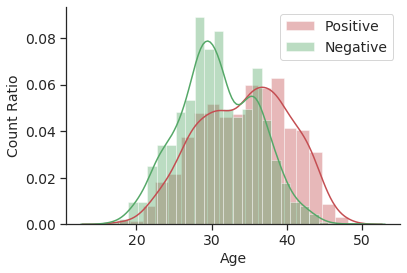

In [15]:
ax = sns.distplot(ori_pheno_df.loc[ori_pheno_df['LABEL']==1,'AGE'], label='Positive', color="r")
ax = sns.distplot(ori_pheno_df.loc[ori_pheno_df['LABEL']==0,'AGE'], label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Age');
ax.set_ylabel('Ratio');

# HEIGHT

In [23]:
pos_height = ori_pheno_df.loc[ori_pheno_df['LABEL']==1,'HEIGHT']
pos_height = pos_height[pos_height.notnull()]
neg_height = ori_pheno_df.loc[ori_pheno_df['LABEL']==0,'HEIGHT']
neg_height = neg_height[neg_height.notnull()]

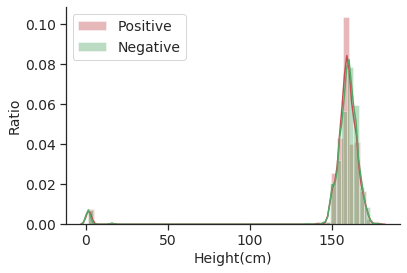

In [26]:
ax = sns.distplot(pos_height, label='Positive', color="r")
ax = sns.distplot(neg_height, label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Height(cm)');
ax.set_ylabel('Ratio');

# Weight

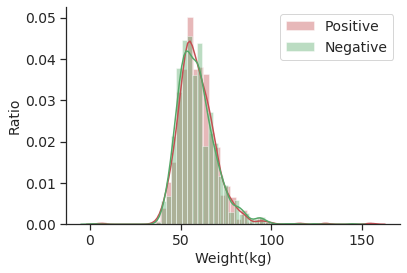

In [27]:
pos_weight = ori_pheno_df.loc[ori_pheno_df['LABEL']==1,'WEIGHT']
pos_weight = pos_weight[pos_weight.notnull()]
neg_weight = ori_pheno_df.loc[ori_pheno_df['LABEL']==0,'WEIGHT']
neg_weight = neg_weight[neg_weight.notnull()]

ax = sns.distplot(pos_weight, label='Positive', color="r")
ax = sns.distplot(neg_weight, label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Weight(kg)');
ax.set_ylabel('Ratio');

# GESTATIONAL WEEK

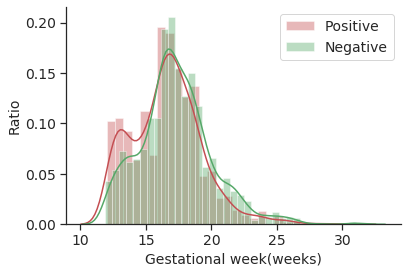

In [28]:
pos_gw = ori_pheno_df.loc[ori_pheno_df['LABEL']==1,'GESTATIONAL_WEEKS_D']
pos_gw = pos_gw[pos_gw.notnull()]
neg_gw = ori_pheno_df.loc[ori_pheno_df['LABEL']==0,'GESTATIONAL_WEEKS_D']
neg_gw = neg_gw[neg_gw.notnull()]

ax = sns.distplot(pos_gw, label='Positive', color="r")
ax = sns.distplot(neg_gw, label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Gestational week(weeks)');
ax.set_ylabel('Ratio');

# FF

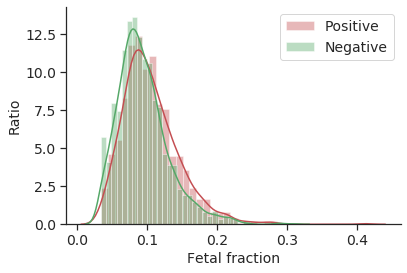

In [29]:
pos_ff = ori_pheno_df.loc[ori_pheno_df['LABEL']==1,'FF']
pos_ff = pos_ff[pos_ff.notnull()]
neg_ff = ori_pheno_df.loc[ori_pheno_df['LABEL']==0,'FF']
neg_ff = neg_ff[neg_ff.notnull()]

ax = sns.distplot(pos_ff, label='Positive', color="r")
ax = sns.distplot(neg_ff, label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Fetal fraction');
ax.set_ylabel('Ratio');

# Imputation

In [41]:
def separate_df(in_df, sep_colsnames):

    t_df = in_df.copy()
    sub_df = t_df[sep_colsnames]
    main_df = t_df.drop(columns=sep_colsnames)
    main_colnames = list(main_df.columns)
    main_values = main_df.values

    return sub_df, main_colnames, main_values

In [42]:
ori_pheno_df = get_pheno_data(chr=chr, del_outliers=True)
data_symboles, data_colnames, data_values = separate_df(ori_pheno_df, ['SAMPLE_NUM', 'LABEL'])

the orignal # of samples in training set: 2524
the orignal # of samples in testing set: 281


In [43]:
data_root_dir = get_config()['data_dir']['data_root_dir']
imputer_fname = os.path.join(data_root_dir, 'model_update/chr{}_ens_pheno-imputor.pkl'.format(chr))
pheno_imputor = joblib.load(imputer_fname)
data_imputed = pheno_imputor.transform(data_values)

In [48]:
# calculate BMI
data_bmi = data_imputed[:, 2] / ((data_imputed[:, 1] / 100.0) ** 2)
data_imputed_bmi = np.hstack((data_imputed, data_bmi.reshape(-1, 1)))

data_trans_df = pd.DataFrame(data=data_imputed_bmi, columns=data_colnames + ['BMI'])
data_trans_df[['SAMPLE_NUM', 'LABEL']]=data_symboles

# Age

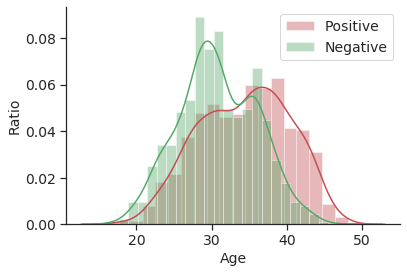

In [50]:
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==1,'AGE'], label='Positive', color="r")
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==0,'AGE'], label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Age');
ax.set_ylabel('Ratio');

# Height

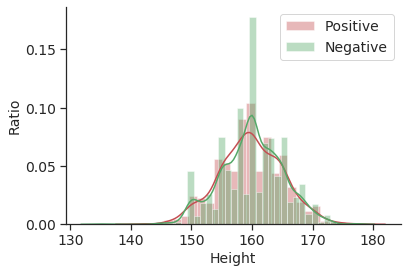

In [55]:
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==1,'HEIGHT'], label='Positive', color="r")
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==0,'HEIGHT'], label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Height');
ax.set_ylabel('Ratio');

# Weight

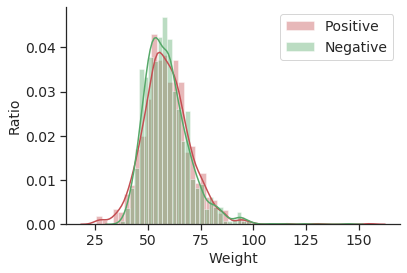

In [56]:
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==1,'WEIGHT'], label='Positive', color="r")
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==0,'WEIGHT'], label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Weight');
ax.set_ylabel('Ratio');

# FF

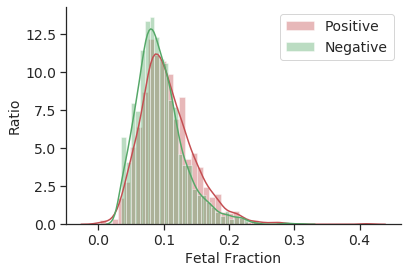

In [60]:
pos_ff = data_trans_df.loc[data_trans_df['LABEL']==1,'FF'].values
pos_ff = pos_ff[pos_ff>0]
neg_ff = data_trans_df.loc[data_trans_df['LABEL']==0,'FF'].values
neg_ff = neg_ff[neg_ff>0]

ax = sns.distplot(pos_ff, label='Positive', color="r")
ax = sns.distplot(neg_ff, label='Negative', color="g")
sns.despine()
ax.legend()
ax.set_xlabel('Fetal Fraction');
ax.set_ylabel('Ratio');

# GESTATIONAL WEEK

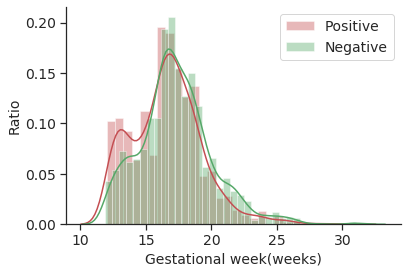

In [61]:
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==1,'GESTATIONAL_WEEKS_D'], label='Positive', color="r")
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==0,'GESTATIONAL_WEEKS_D'], label='Negative', color="g")

sns.despine()
ax.legend()
ax.set_xlabel('Gestational week(weeks)');
ax.set_ylabel('Ratio');

# BMI

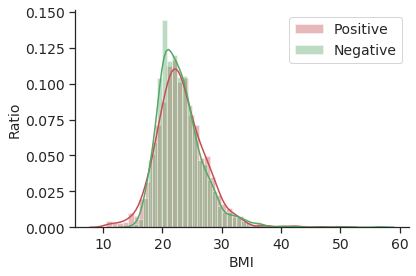

In [62]:
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==1,'BMI'], label='Positive', color="r")
ax = sns.distplot(data_trans_df.loc[data_trans_df['LABEL']==0,'BMI'], label='Negative', color="g")

sns.despine()
ax.legend()
ax.set_xlabel('BMI');
ax.set_ylabel('Ratio');